# EDA Banking Lead Conversion Prediction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

## Read Data

Data source: https://www.kaggle.com/datasets/arashnic/banking-loan-prediction

In [3]:
data_path = '../data/Banking | Marketing | Leads Conversion Data/train_loan/train.csv'
df = pd.read_csv(data_path)
print('total data size is', df.shape[0])

total data size is 69713


In [4]:
df.columns

Index(['ID', 'Gender', 'DOB', 'Lead_Creation_Date', 'City_Code',
       'City_Category', 'Employer_Code', 'Employer_Category1',
       'Employer_Category2', 'Monthly_Income',
       'Customer_Existing_Primary_Bank_Code', 'Primary_Bank_Type', 'Contacted',
       'Source', 'Source_Category', 'Existing_EMI', 'Loan_Amount',
       'Loan_Period', 'Interest_Rate', 'EMI', 'Var1', 'Approved'],
      dtype='object')

In [5]:
label_col = 'Approved'
index_col = 'ID'
feat_cols = ['Gender', 'DOB', 'Lead_Creation_Date', 'City_Code', 'City_Category',
             'Employer_Code', 'Employer_Category1', 'Employer_Category2', 'Monthly_Income',
             'Customer_Existing_Primary_Bank_Code', 'Primary_Bank_Type', 'Contacted',
             'Source', 'Source_Category', 'Existing_EMI', 'EMI', 'Var1'
            ]

## Exploratory Data Analysis

In [6]:
df[df.Loan_Amount.isnull()]

,ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,...,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
0,APPC90493171225,Female,23/07/79,15/07/16,C10001,A,COM0044082,A,4.0,2000.0,...,N,S122,G,0.0,NaN,NaN,NaN,NaN,0,0
5,APPI90914237819,Female,23/12/88,01/07/16,C10402,C,COM0007740,A,4.0,7000.0,...,N,S133,B,0.0,NaN,NaN,NaN,NaN,0,0
9,APPN60714112334,Female,13/12/90,02/07/16,C10014,B,COM0042212,A,4.0,2500.0,...,N,S122,B,0.0,NaN,NaN,NaN,NaN,0,0
12,APPT10286486907,Female,08/03/91,01/07/16,C10001,A,COM0003151,C,4.0,2000.0,...,N,S122,B,0.0,NaN,NaN,NaN,NaN,0,0
15,APPY60885704429,Female,27/03/88,01/07/16,C10006,A,COM0033048,A,4.0,1200.0,...,N,S133,C,0.0,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69691,APPV60899685135,Female,30/12/82,30/09/16,C10003,A,COM0000021,A,1.0,5500.0,...,N,S122,G,1854.9,NaN,NaN,NaN,NaN,10,0
69700,APPG50483428223,Female,02/01/64,30/09/16,C10078,C,COM0002784,A,4.0,5152.4,...,N,S122,G,2364.8,NaN,NaN,NaN,NaN,0,0
69701,APPI40463125441,Female,05/08/91,30/09/16,C10126,C,COM0001852,C,4.0,1300.0,...,N,S122,G,500.0,NaN,NaN,NaN,NaN,0,0
69708,APPU90955789628,Female,31/07/83,30/09/16,C10006,A,COM0000010,A,1.0,4900.0,...,N,S122,G,0.0,NaN,NaN,NaN,NaN,10,0


In [11]:
df[df.duplicated(subset=feat_cols, keep=False)]

,ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,...,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
144,APPF30910113718,Female,06/02/90,01/07/16,C10268,C,COM0000196,C,4.0,4800.0,...,N,S133,B,2100.0,NaN,NaN,NaN,NaN,0,0
147,APPJ10903445104,Female,06/02/90,01/07/16,C10268,C,COM0000196,C,4.0,4800.0,...,N,S133,B,2100.0,NaN,NaN,NaN,NaN,0,0
205,APPZ50631657908,Female,05/10/94,01/07/16,C10001,A,COM0003046,A,4.0,1500.0,...,N,S122,B,0.0,NaN,NaN,NaN,NaN,0,0
207,APPC70100241238,Female,05/10/94,01/07/16,C10001,A,COM0003046,A,4.0,1500.0,...,N,S122,B,0.0,NaN,NaN,NaN,NaN,0,0
451,APPF20862639728,Male,28/04/84,01/07/16,C10006,A,COM0000194,C,4.0,2200.0,...,Y,S133,C,0.0,32000.0,5.0,16.75,791.0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69433,APPK10393425814,Female,31/07/90,30/09/16,C10070,C,COM0014516,B,4.0,1850.0,...,N,S122,G,0.0,NaN,NaN,NaN,NaN,0,0
69564,APPF70069792503,Female,21/09/92,30/09/16,C10006,A,COM0008067,A,4.0,2038.0,...,N,S122,G,170.0,NaN,NaN,NaN,NaN,0,0
69566,APPH70973679738,Female,21/09/92,30/09/16,C10006,A,COM0008067,A,4.0,2038.0,...,N,S122,G,170.0,NaN,NaN,NaN,NaN,0,0
69584,APPC70406717815,Female,07/04/93,30/09/16,C10016,B,COM0001474,C,4.0,850.0,...,N,S122,G,0.0,NaN,NaN,NaN,NaN,0,0


### Lead Response

In [153]:
df['Apply'] = np.where(df['Loan_Amount']>0, 1, 0)
df['Apply'].mean()

0.6025275056302268

In [151]:
df['Approved'].mean()

0.014631417382697631

### Gender

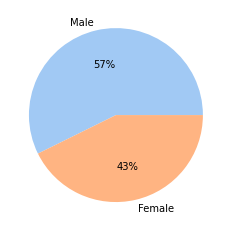

In [36]:
gender = df['Gender'].value_counts()
colors = sns.color_palette('pastel')[0:5]
plt.pie(gender, labels=gender.index, colors=colors, autopct='%.0f%%');

### Age

In [12]:
df['DOB'] = df['DOB'].apply(pd.to_datetime)
df['Lead_Creation_Date'] = df['Lead_Creation_Date'].apply(pd.to_datetime)


In [19]:
df['Age'] = (df['Lead_Creation_Date'] - df['DOB'])/ np.timedelta64(1, 'Y')


In [29]:
print('the total of minus age customers is ', (df['Age']<0).sum())
   

the total of minus age customers is  4241


In [31]:
df['Age'] = np.where(df['Age'] < 0, np.nan, df['Age'])
df['Age'].describe()

count    65457.000000
mean        29.555024
std          5.082830
min         16.802535
25%         25.815725
50%         28.824685
75%         32.646803
max         44.816800
Name: Age, dtype: float64

<AxesSubplot:xlabel='Approved', ylabel='Age'>

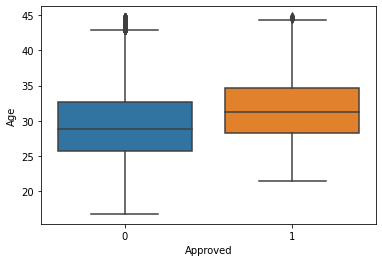

In [32]:
sns.boxplot(data=df, y='Age', x=label_col)

### City
#### City Code

In [39]:
city_codes = df['City_Code'].value_counts()

In [43]:
city_code_agg = df.groupby('City_Code').agg({
    'ID': 'count',
    label_col: 'mean'
}).reset_index()

In [50]:
city_code_agg = city_code_agg[city_code_agg['ID'] > 500]
city_code_agg.head()

,City_Code,ID,Approved
0,C10001,10007,0.021685
1,C10002,8716,0.016521
2,C10003,8666,0.015117
3,C10004,5843,0.011809
4,C10005,5564,0.010244


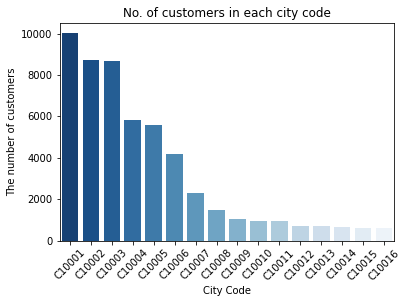

In [62]:
sns.barplot(x="City_Code", y="ID", data=city_code_agg, palette="Blues_r")
plt.xticks(rotation=45)
plt.ylabel('The number of customers')
plt.xlabel('City Code')
plt.title('No. of customers in each city code')
plt.show()

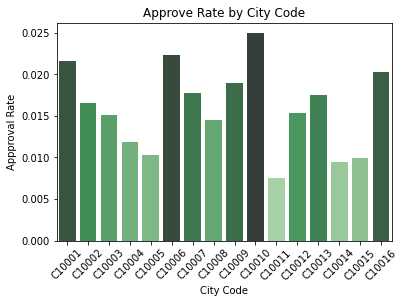

In [73]:
# define the color palette of different colors
pal = sns.color_palette("Greens_d", len(city_code_agg))
# use argsort method
rank = city_code_agg["Approved"].argsort()[::-1].argsort()
sns.barplot(x="City_Code", y="Approved", data=city_code_agg, palette=np.array(pal[::-1])[rank])
plt.xticks(rotation=45)
plt.ylabel('Appproval Rate')
plt.xlabel('City Code')
plt.title('Approve Rate by City Code')
plt.show()

#### City Category

In [78]:
city_cat_agg = df.groupby('City_Category').agg({
    'ID': 'count',
    label_col: 'mean'
}).reset_index()

In [80]:
city_cat_agg

,City_Category,ID,Approved
0,A,49885,0.016558
1,B,7320,0.013388
2,C,11694,0.008038


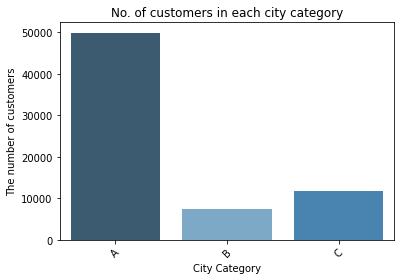

In [89]:
# define the color palette of different colors
pal = sns.color_palette("Blues_d", len(city_cat_agg))
# use argsort method
rank = city_cat_agg["ID"].argsort()[::-1].argsort()
sns.barplot(x="City_Category", y="ID", data=city_cat_agg, palette=np.array(pal[::-1])[rank])
plt.xticks(rotation=45)
plt.ylabel('The number of customers')
plt.xlabel('City Category')
plt.title('No. of customers in each city category')
plt.show()

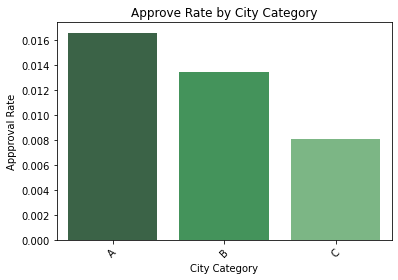

In [91]:
# define the color palette of different colors
pal = sns.color_palette("Greens_d", len(city_cat_agg))
# use argsort method
rank = city_cat_agg["Approved"].argsort()[::-1].argsort()
sns.barplot(x="City_Category", y="Approved", data=city_cat_agg, palette=np.array(pal[::-1])[rank])
plt.xticks(rotation=45)
plt.ylabel('Appproval Rate')
plt.xlabel('City Category')
plt.title('Approve Rate by City Category')
plt.show()

### Employer

#### Employer Code

In [94]:
df['Employer_Code'].nunique()

36617

#### Employer Category1

In [97]:
emp_cat1_agg = df.groupby('Employer_Category1').agg({
    'ID': 'count',
    label_col: 'mean'
}).reset_index()

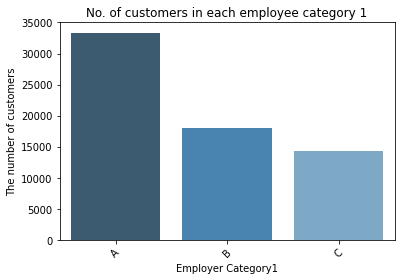

In [98]:
# define the color palette of different colors
pal = sns.color_palette("Blues_d", len(emp_cat1_agg))
# use argsort method
rank = emp_cat1_agg["ID"].argsort()[::-1].argsort()
sns.barplot(x="Employer_Category1", y="ID", data=emp_cat1_agg, palette=np.array(pal[::-1])[rank])
plt.xticks(rotation=45)
plt.ylabel('The number of customers')
plt.xlabel('Employer Category1')
plt.title('No. of customers in each employee category 1')
plt.show()

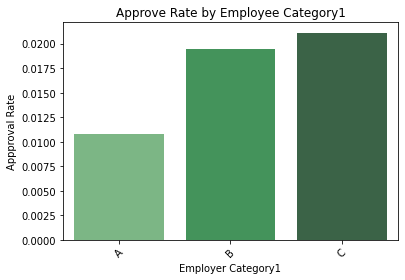

In [103]:
pal = sns.color_palette("Greens_d", len(emp_cat1_agg))
# use argsort method
rank = emp_cat1_agg["Approved"].argsort()[::-1].argsort()
sns.barplot(x="Employer_Category1", y="Approved", data=emp_cat1_agg, palette=np.array(pal[::-1])[rank])
plt.xticks(rotation=45)
plt.ylabel('Appproval Rate')
plt.xlabel('Employer Category1')
plt.title('Approve Rate by Employee Category1')
plt.show()

#### Employer Category2

In [102]:
emp_cat2_agg = df.groupby('Employer_Category2').agg({
    'ID': 'count',
    label_col: 'mean'
}).reset_index()

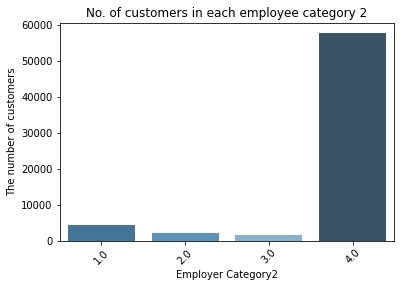

In [104]:
# define the color palette of different colors
pal = sns.color_palette("Blues_d", len(emp_cat2_agg))
# use argsort method
rank = emp_cat2_agg["ID"].argsort()[::-1].argsort()
sns.barplot(x="Employer_Category2", y="ID", data=emp_cat2_agg, palette=np.array(pal[::-1])[rank])
plt.xticks(rotation=45)
plt.ylabel('The number of customers')
plt.xlabel('Employer Category2')
plt.title('No. of customers in each employee category 2')
plt.show()

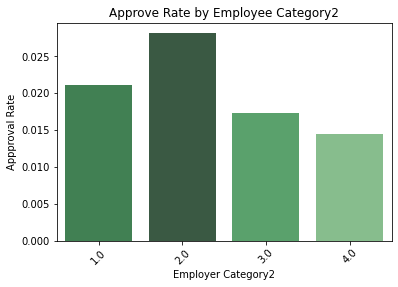

In [105]:
pal = sns.color_palette("Greens_d", len(emp_cat2_agg))
# use argsort method
rank = emp_cat2_agg["Approved"].argsort()[::-1].argsort()
sns.barplot(x="Employer_Category2", y="Approved", data=emp_cat2_agg, palette=np.array(pal[::-1])[rank])
plt.xticks(rotation=45)
plt.ylabel('Appproval Rate')
plt.xlabel('Employer Category2')
plt.title('Approve Rate by Employee Category2')
plt.show()

### Income

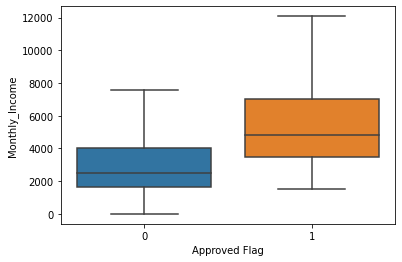

In [110]:
sns.boxplot(data=df, y='Monthly_Income', x=label_col, showfliers=False)
plt.xlabel('Approved Flag')
plt.show()

### Primary Bank Code

In [112]:
df['Customer_Existing_Primary_Bank_Code'].nunique()

57

In [161]:
df[''].nunique()

2

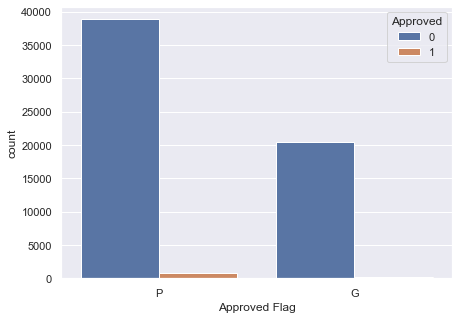

In [162]:
sns.countplot(x="Primary_Bank_Type", hue=label_col, data=df)
plt.xlabel('Approved Flag')
plt.show()

### Contacted

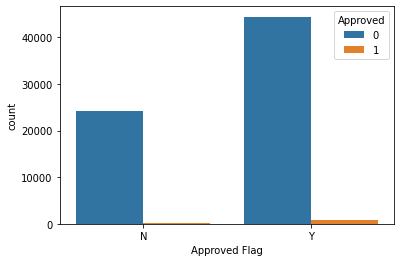

In [120]:
sns.countplot(x="Contacted", hue=label_col, data=df)
plt.xlabel('Approved Flag')
plt.show()

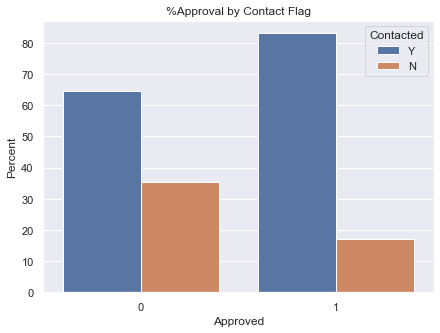

In [139]:
ctc_df = df.groupby(label_col)['Contacted'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
sns.set(rc={"figure.figsize":(7, 5)})
sns.barplot(x="Approved", y='Percent', hue='Contacted', data=ctc_df)
plt.title("%Approval by Contact Flag")
plt.show()

### Source and Source Category

In [131]:
df['Source'].nunique()

29

In [132]:
df['Source_Category'].nunique()

7

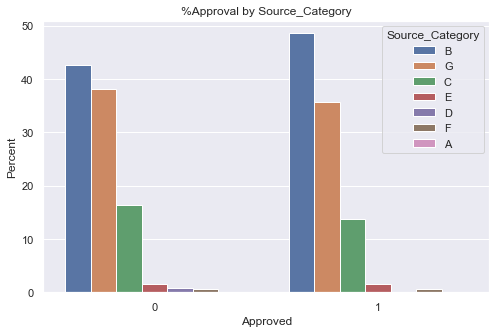

In [137]:
ctc_df = df.groupby(label_col)['Source_Category'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
sns.set(rc={"figure.figsize":(8, 5)})
sns.barplot(x="Approved", y='Percent', hue='Source_Category', data=ctc_df)
plt.title("%Approval by Source_Category")
plt.show()

### Existing EMI

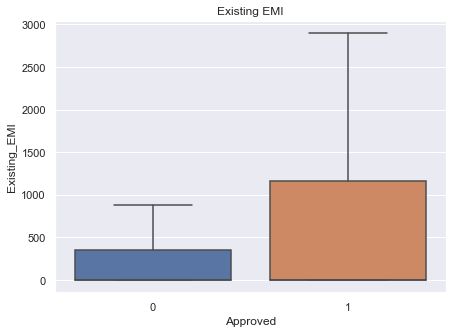

In [143]:
sns.boxplot(data=df, y='Existing_EMI', x=label_col, showfliers=False)
plt.title("Existing EMI")
plt.show()

### Loan Detail
#### Loan Amount

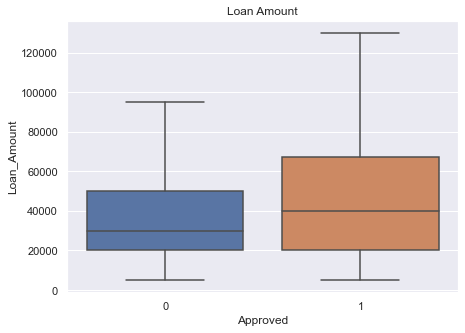

In [145]:
sns.boxplot(data=df, y='Loan_Amount', x=label_col, showfliers=False)
plt.title("Loan Amount")
plt.show()

#### Loan Period

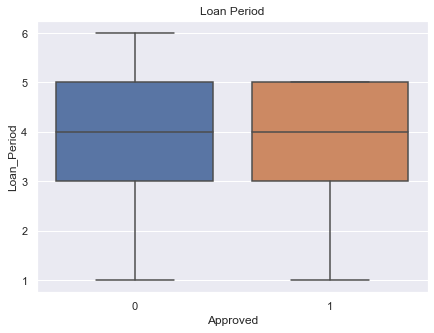

In [154]:
sns.boxplot(data=df, y='Loan_Period', x=label_col, showfliers=False)
plt.title("Loan Period")
plt.show()

#### Interest Rate

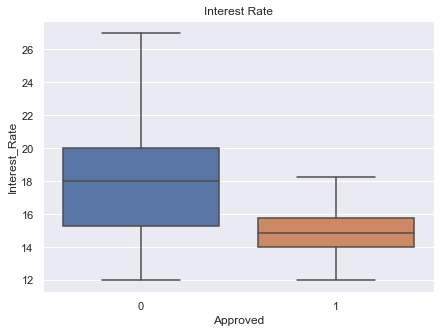

In [156]:
sns.boxplot(data=df, y='Interest_Rate', x=label_col, showfliers=False)
plt.title("Interest Rate")
plt.show()

### Var

In [158]:
df['Var1'].nunique()

5

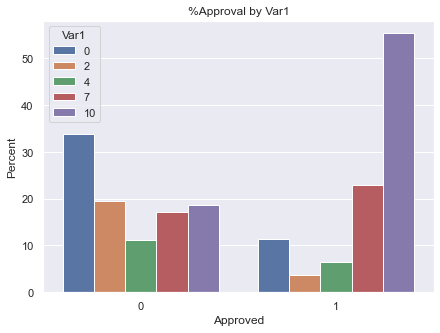

In [160]:
var_df = df.groupby(label_col)['Var1'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
sns.set(rc={"figure.figsize":(7, 5)})
sns.barplot(x="Approved", y='Percent', hue='Var1', data=var_df)
plt.title("%Approval by Var1")
plt.show()